In [1]:
# %%
# Cell 1: Imports & Global Configuration

import os, glob, time, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from operator import truediv
import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim


# Paths
PROCESSED_DIR = 'prepocessing/processed_cubes'
RESULT_DIR    = 'results'
os.makedirs(RESULT_DIR, exist_ok=True)

# Hyperparameters
WS        = 8        # patch size
NC        = 15        # number of spectral components
DLM       = 'PCA'       # PCA dimensionality limit multiplier
trRatio   = 0.01
vrRatio   = 0.09    
teRatio   = 0.90
randomState = 345

batch_size = 56
epochs     = 50
lr = 0.001

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# %%  
# Cell 2: Load Preprocessed Cubes & Labels

def LoadHSIData(data_dir):
    files = glob.glob(os.path.join(data_dir, "*.npz"))
    species = sorted({os.path.basename(f).split('_block')[0] for f in files})
    label_map = {sp:i for i,sp in enumerate(species)}
    cubes, labels, names = [], [], []
    for f in files:
        sp = os.path.basename(f).split('_block')[0]
        arr = np.load(f)['block']  # (H, W, C)
        cubes.append(arr)
        labels.append(label_map[sp])
        names.append(sp)
    return cubes, np.array(labels), names, species

cubes, cube_labels, cube_names, species_list = LoadHSIData(PROCESSED_DIR)
num_classes = len(species_list)
print(f"Loaded {len(cubes)} blocks from {num_classes} species")


Loaded 26 blocks from 9 species


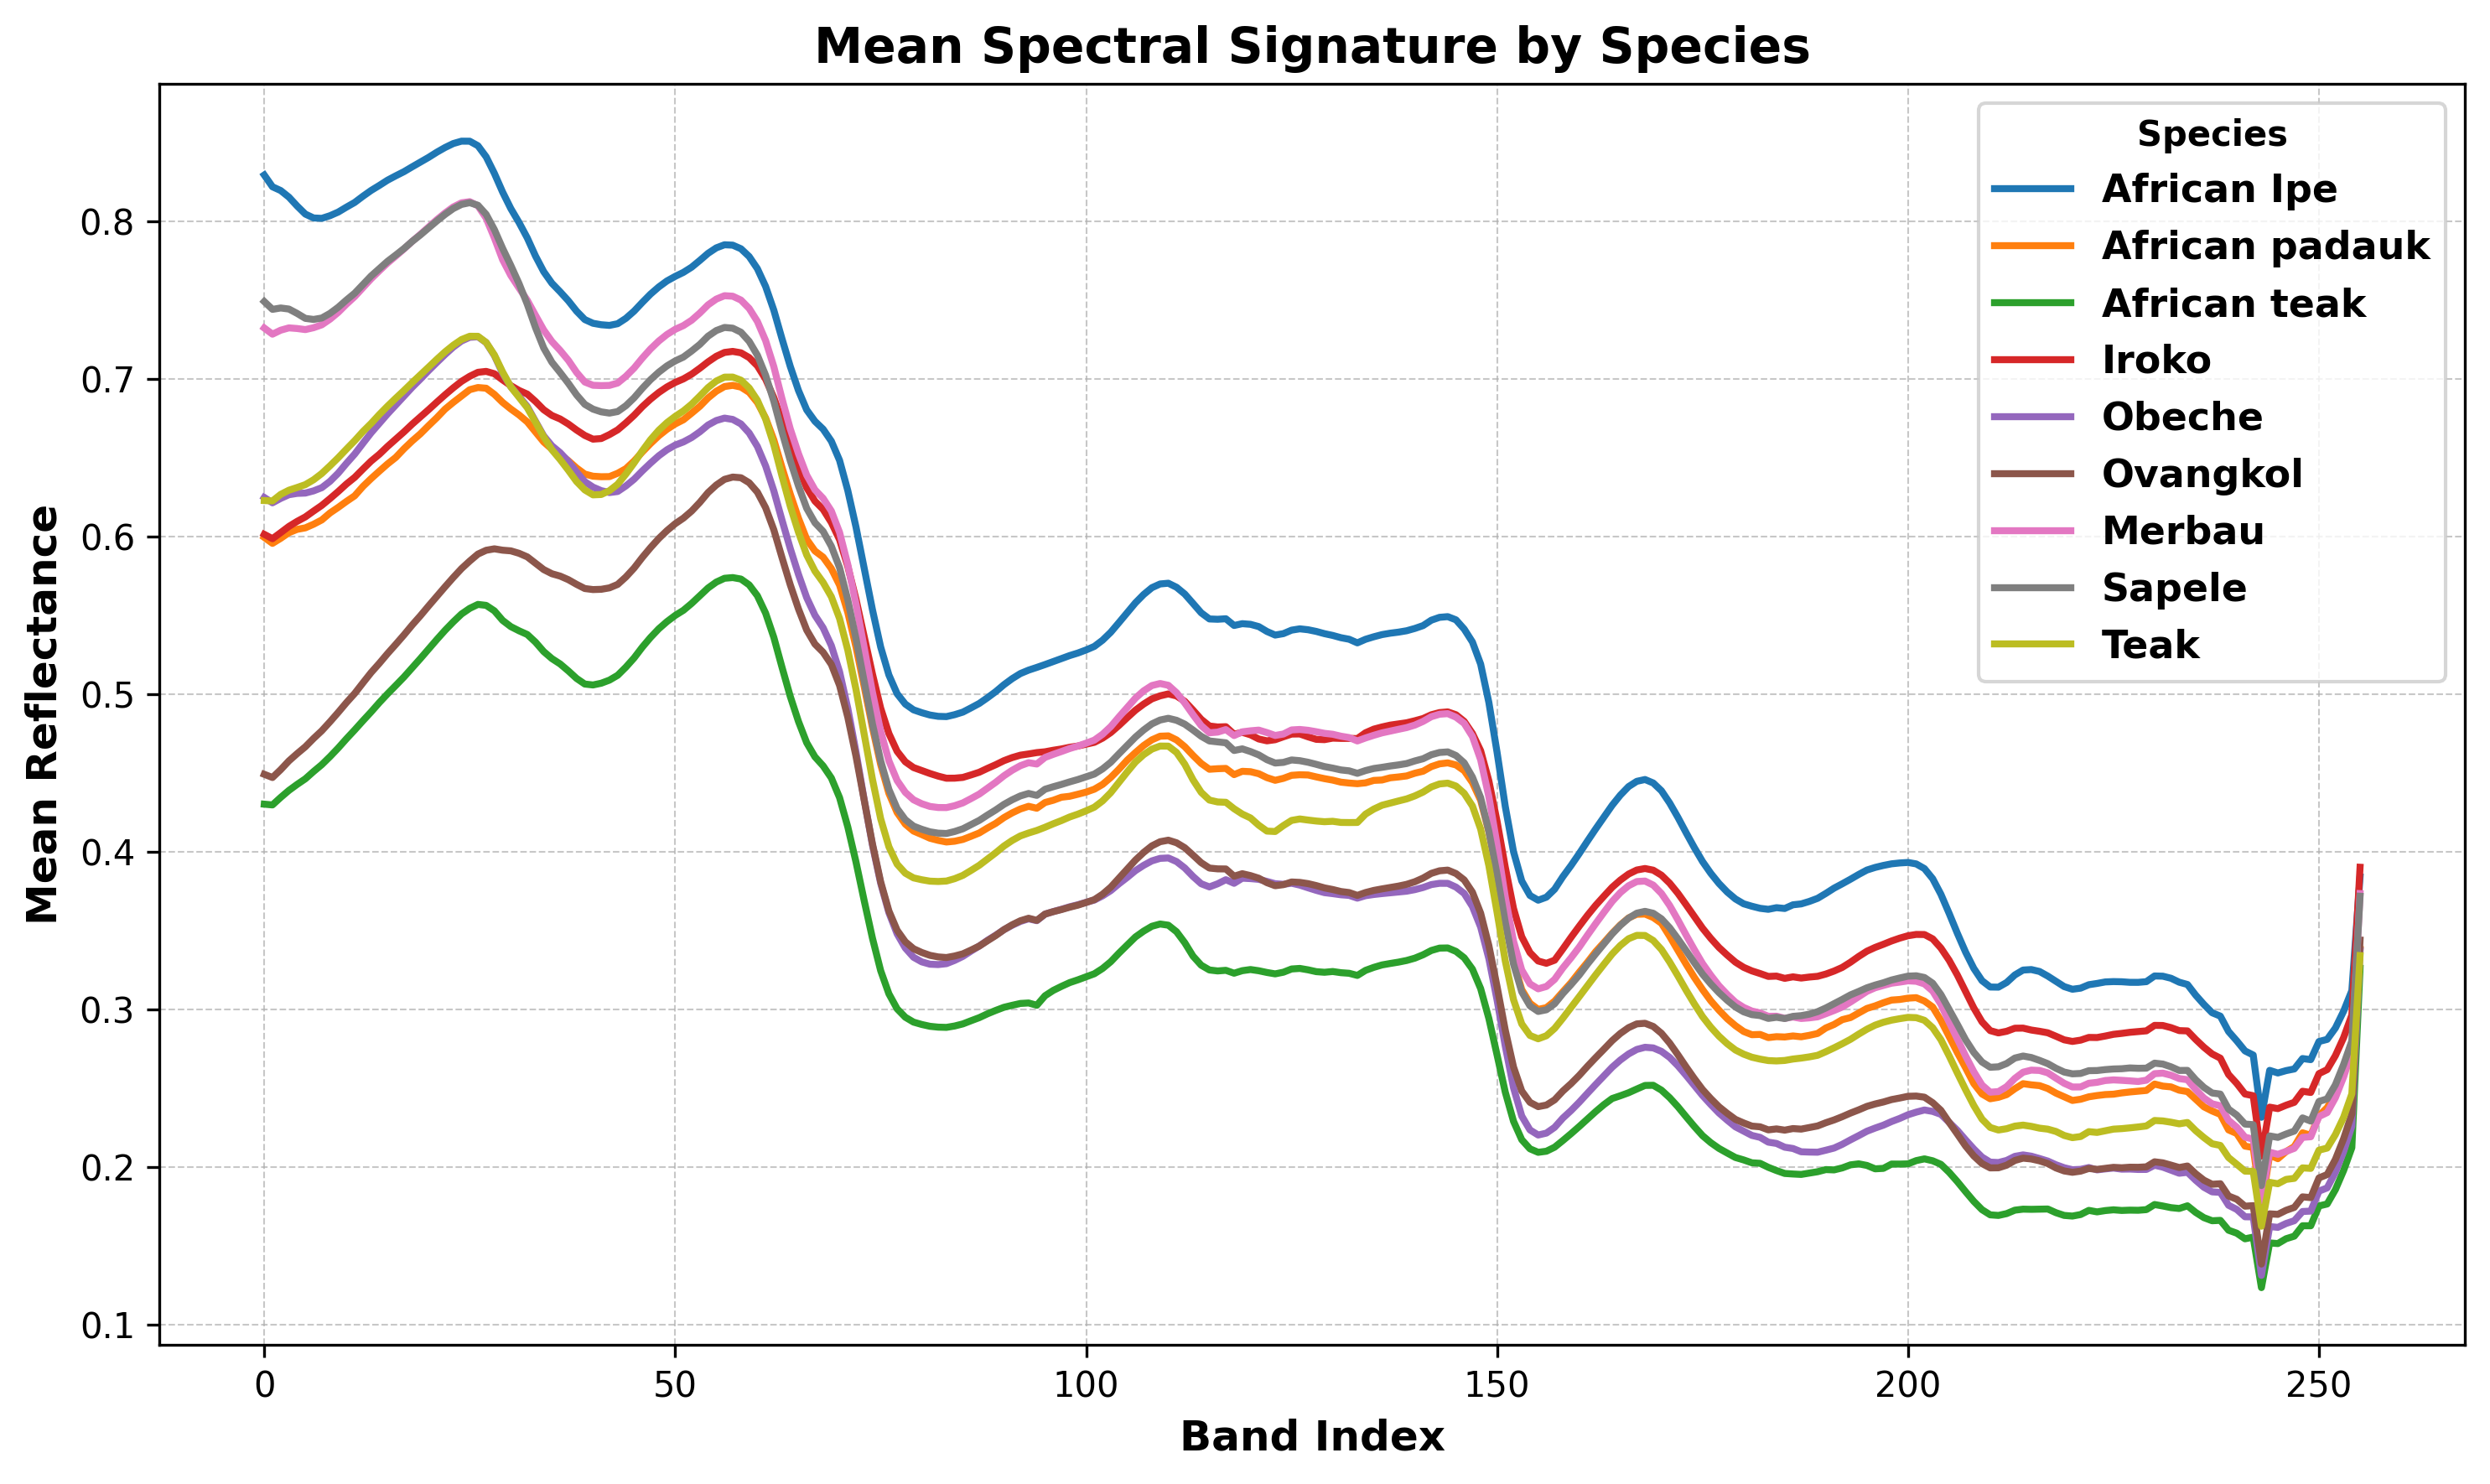

In [3]:
# Human‐readable labels, in exact order of your species_list
display_labels = [
    "African Ipe",
    "African padauk",
    "African teak",
    "Iroko",
    "Obeche",
    "Ovangkol",
    "Merbau",
    "Sapele",
    "Teak",
]

# Compute mean spectra as before
mean_spectra = {sp: [] for sp in species_list}
for arr, name in zip(cubes, cube_names):
    mean_spectra[name].append(arr.mean(axis=(0, 1)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
for sp, lbl in zip(species_list, display_labels):
    spec = np.stack(mean_spectra[sp], axis=0).mean(axis=0)
    ax.plot(spec, label=lbl, linewidth=2)

ax.set_title("Mean Spectral Signature by Species", fontweight="bold", fontsize=14)
ax.set_xlabel("Band Index", fontweight="bold", fontsize=12)
ax.set_ylabel("Mean Reflectance", fontweight="bold", fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Single legend inside the plot
leg = ax.legend(
    loc="upper right",
    frameon=True,
    fontsize=11,
    title="Species",
    title_fontproperties={"weight": "bold"},
)
for text in leg.get_texts():
    text.set_weight("bold")

plt.tight_layout()
plt.savefig(os.path.join(RESULT_DIR, "mean_spectra_custom_labels.png"), dpi=300)
# plt.show()

In [4]:
# %%  
# Cell 4 (Generalized): Global Dimensionality Reduction Fit & Apply


# 1) Aggregate all pixel spectra
all_pixels = np.vstack([arr.reshape(-1, arr.shape[2]) for arr in cubes])
print("Aggregated pixels:", all_pixels.shape)

# 2) Choose and fit the DR model once, based on DLM
if DLM == 'PCA':
    dr_model = PCA(n_components=NC, whiten=True, random_state=0)
elif DLM == 'iPCA':
    dr_model = IncrementalPCA(n_components=NC)
elif DLM == 'KPCA':
    dr_model = KernelPCA(kernel='rbf', n_components=NC,
                        fit_inverse_transform=True, random_state=0)
elif DLM == 'SPCA':
    dr_model = SparsePCA(n_components=NC, alpha=1e-4, random_state=0)
elif DLM == 'SVD':
    dr_model = TruncatedSVD(n_components=NC, random_state=0)
else:
    raise ValueError(f"Unknown DLM: {DLM}")

# If iPCA, do a partial fit in batches
if DLM == 'iPCA':
    for batch in np.array_split(all_pixels, 256):
        dr_model.partial_fit(batch)
else:
    dr_model.fit(all_pixels)

# 3) Save the DR model
joblib.dump(dr_model, os.path.join(RESULT_DIR, f"{DLM}_model.joblib"))
print(f"Fitted {DLM}: input bands → {NC} components.")

# 4) Apply the same transformation to each cube
reduced_cubes = []
for arr in cubes:
    H, W, B = arr.shape
    flat = arr.reshape(-1, B)
    red  = dr_model.transform(flat)
    reduced_cubes.append(red.reshape(H, W, NC))

print(f"Applied {DLM} to all cubes.")


Aggregated pixels: (1162087, 256)
Fitted PCA: input bands → 15 components.
Applied PCA to all cubes.


In [5]:
# %%  
# Cell 5: Create Spatial-Spectral Patches & Labels

def ImageCubes(HSI_list, labels, WS=14):
    patches, patch_labels = [], []
    for HSI, lab in zip(HSI_list, labels):
        H, W, NB = HSI.shape
        pad = WS//2
        padded = np.pad(HSI, ((pad,pad),(pad,pad),(0,0)), mode='constant')
        for i in range(pad, pad+H):
            for j in range(pad, pad+W):
                cube = padded[i-pad:i+pad, j-pad:j+pad, :]
                patches.append(cube)
                patch_labels.append(lab)
    patches = np.stack(patches, axis=0)              # (N, WS, WS, NC)
    patch_labels = np.array(patch_labels)            # (N,)
    return patches, patch_labels

patches, patch_labels = ImageCubes(reduced_cubes, cube_labels, WS)
print(f"Created {patches.shape[0]} patches of shape {patches.shape[1:]}")

Created 1162087 patches of shape (8, 8, 15)


In [6]:
# %%  
# Cell 6: Train/Val/Test Split & DataLoaders

def TrTeSplit(X, y, trRatio, vrRatio, teRatio, rs=345):
    X_trte, X_te, y_trte, y_te = train_test_split(X, y, test_size=teRatio,
                                                  random_state=rs, stratify=y)
    vr = vrRatio/(trRatio+vrRatio)
    X_tr, X_va, y_tr, y_va = train_test_split(X_trte, y_trte, test_size=vr,
                                              random_state=rs, stratify=y_trte)
    return X_tr, X_va, X_te, y_tr, y_va, y_te

X_tr, X_va, X_te, y_tr, y_va, y_te = TrTeSplit(patches, patch_labels,
                                               trRatio, vrRatio, teRatio, randomState)

# convert to tensors and dataloaders
def to_loader(X, y, batch_size, shuffle=True):
    # X: (N, WS, WS, NC) → (N, NC, WS, WS)
    X = np.transpose(X, (0,3,1,2)).astype(np.float32)
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2)

train_dl = to_loader(X_tr, y_tr, batch_size)
val_dl   = to_loader(X_va, y_va, batch_size, shuffle=False)
test_dl  = to_loader(X_te, y_te, batch_size, shuffle=False)

print(f"Splits → Train: {len(X_tr)}, Val: {len(X_va)}, Test: {len(X_te)}")

Splits → Train: 11620, Val: 104588, Test: 1045879


In [7]:
# %%
# Cell X: PyTorch Implementations of CNN2D and CNN3D



class CNN2D(nn.Module):
    def __init__(self, ws, in_channels, num_classes):
        """
        2D CNN replicating the Keras CNN2D architecture.
        ws: spatial window size (height and width)
        in_channels: number of spectral bands (k)
        num_classes: number of output classes
        """
        super().__init__()
        # Convolutional layers with 'same' padding
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Compute flattened feature size: 64 * ws * ws
        self.flatten_size = 64 * ws * ws
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, self.flatten_size // 4)  # 128
        self.drop2 = nn.Dropout(0.4)
        self.out = nn.Linear(self.flatten_size // 4, num_classes)

    def forward(self, x):
        # x: (B, in_channels, ws, ws)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.out(x)


class CNN3D(nn.Module):
    def __init__(self, ws, in_bands, num_classes):
        """
        3D CNN replicating the Keras CNN3D architecture.
        ws: spatial window size (height and width)
        in_bands: number of spectral bands (k)
        num_classes: number of output classes
        """
        super().__init__()
        # 'same' padding = floor(kernel/2) for each dim
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        self.conv4 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        # After conv+pool, the spatial dims unchanged because no pooling in Keras version
        # Flatten size = 64 * in_bands * ws * ws
        self.flatten_size = 64 * in_bands * ws * ws
        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (B, in_bands, ws, ws)
        # add channel dim: (B, 1, in_bands, ws, ws)
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

In [8]:
# ─── Positional encoding ───────────────────────────────────────────────────
# ─── 1) Positional Encoding with a default device ───────────────────────────
def get_positional_encoding(seq_len, d_emb, device="cpu"):
    """
    Returns a (1, seq_len, d_emb) sinusoidal positional encoding,
    living initially on `device`.
    """
    pe = torch.zeros(seq_len, d_emb, device=device)
    pos = torch.arange(seq_len, device=device).unsqueeze(1)
    div = torch.exp(
        torch.arange(0, d_emb, 2, device=device) * -(math.log(10000.0) / d_emb)
    )
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)  # shape (1, seq_len, d_emb)


# ─── 2) Transformer Block (unchanged) ───────────────────────────────────────
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(
            d_model, num_heads, dropout=dropout_rate, batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn, _ = self.mha(x, x, x)
        x = self.norm1(x + self.drop(attn))
        f = self.ffn(x)
        return self.norm2(x + self.drop(f))

# SSFormer in PyTorch
class SSFormer(nn.Module):
    def __init__(
        self,
        WS,  # patch height & width
        k,  # number of slices per sample
        num_classes,
        num_layers=4,
        num_heads=8,
        dff=256,
        dropout=0.1,
    ):
        super().__init__()

        # 1) spatial embed: conv over each slice
        self.patch_embed = nn.Conv3d(
            in_channels=1,
            out_channels=128,
            kernel_size=(1, WS, WS),
            stride=(1, WS, WS),
        )

        # 2) CLS token + positional buffer for (k + 1) tokens
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 128))
        pe = get_positional_encoding(k + 1, 128)  # shape (1, 1+k, 128)
        self.register_buffer("pos_encode", pe)

        # 3) Transformer layers
        self.transformers = nn.ModuleList(
            [TransformerBlock(128, num_heads, dff, dropout) for _ in range(num_layers)]
        )

        # 4) MLP head: concat CLS + first patch token
        self.mlp = nn.Sequential(
            nn.Linear(128 * 2, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, num_classes),
        )

    def forward(self, x):
        # x: (B, k, WS, WS)
        B = x.size(0)

        # embed → (B,128,k,1,1)
        x = x.unsqueeze(1)  # (B,1,k,WS,WS)
        p = self.patch_embed(x)  # (B,128,k,1,1)

        # flatten → (B, k, 128)
        p = p.view(B, 128, -1).permute(0, 2, 1)

        # prepend CLS → (B, k+1, 128)
        cls = self.cls_token.expand(B, -1, -1)
        seq = torch.cat([cls, p], dim=1)

        # add positional encoding (slice to seq length)
        seq = seq + self.pos_encode[:, : seq.size(1), :]

        # transformer stack
        for layer in self.transformers:
            seq = layer(seq)

        # take CLS & first patch token → (B, 256)
        combined = torch.cat([seq[:, 0], seq[:, 1]], dim=1)

        return self.mlp(combined)

In [9]:
def get_pos_enc(seq_len, d_model, device="cpu"):
    """
    Sinusoidal positional encoding, shape (1, seq_len, d_model).
    """
    pe = torch.zeros(seq_len, d_model, device=device)
    pos = torch.arange(seq_len, device=device).unsqueeze(1)
    div = torch.exp(
        torch.arange(0, d_model, 2, device=device) * -(math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe.unsqueeze(0)


class LinearAttention(nn.Module):
    """
    Light-weight, O(N) “flash” attention via PyTorch's scaled_dot_product_attention.
    """

    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (d_model // num_heads) ** -0.5
        self.to_qkv = nn.Linear(d_model, d_model * 3, bias=False)
        self.to_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, L, D = x.shape
        H = self.num_heads

        # project QKV and split heads
        qkv = self.to_qkv(x)  # (B, L, 3·D)
        q, k, v = qkv.chunk(3, dim=-1)

        # reshape to (B, H, L, D/H)
        q = q.view(B, L, H, D // H).transpose(1, 2)
        k = k.view(B, L, H, D // H).transpose(1, 2)
        v = v.view(B, L, H, D // H).transpose(1, 2)

        # Flash (scaled dot‑product) attention
        attn = F.scaled_dot_product_attention(
            q, k, v, attn_mask=None, dropout_p=self.dropout.p, is_causal=False
        )  # (B, H, L, D/H)

        # merge heads and final linear
        attn = attn.transpose(1, 2).reshape(B, L, D)
        return self.to_out(attn)


class EfficientPatchEmbed(nn.Module):
    """
    Depthwise‐separable 3D convolution patch embed:
      1) dw over spectral (k slices) → (B,1,1,WS,WS)
      2) pw to d_model & patchify → (B, P, d_model)
    """

    def __init__(self, WS, k, d_model):
        super().__init__()
        self.dw = nn.Conv3d(1, 1, kernel_size=(k, 1, 1))
        self.pw = nn.Conv3d(1, d_model, kernel_size=(1, WS, WS), stride=(1, WS, WS))

    def forward(self, x):
        # x: (B, k, WS, WS)
        B = x.size(0)
        x = x.unsqueeze(1)  # (B,1,k,WS,WS)
        x = self.dw(x)  # (B,1,1,WS,WS)
        x = self.pw(x)  # (B,d_model,P,1,1)
        _, C, P, _, _ = x.shape
        x = x.view(B, C, P).permute(0, 2, 1)  # (B, P, d_model)
        return x


class SSLinFormer(nn.Module):
    def __init__(
        self,
        WS,  # patch width/height
        k,  # number of spectral slices
        num_classes,
        d_model=64,
        num_heads=4,
        depth=6,
        dff=None,
        dropout=0.1,
    ):
        super().__init__()
        dff = dff or (d_model // 2)

        # ── Embedding ─────────────────────────────────────
        self.patch_embed = EfficientPatchEmbed(WS, k, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        # register positional encodings as buffers so .to(device) moves them
        pe_s = get_pos_enc(k + 1, d_model)  # (1, k+1, d_model)
        self.register_buffer("spe_pos", pe_s)

        # compute #patches P = (WS//WS)**2  (adjust if you use overlapping patches)
        P = (WS // WS) ** 2
        pe_p = get_pos_enc(P + 1, d_model)  # (1, P+1, d_model)
        self.register_buffer("spa_pos", pe_p)

        # ── Spectral + Spatial Blocks ─────────────────────
        self.spec_blocks = nn.ModuleList()
        self.spa_blocks = nn.ModuleList()
        for _ in range(depth // 2):
            # spectral: attend across k+1 tokens per patch
            self.spec_blocks.append(
                nn.ModuleList(
                    [
                        LinearAttention(d_model, num_heads, dropout),
                        nn.LayerNorm(d_model),
                        nn.Sequential(
                            nn.Linear(d_model, dff),
                            nn.ReLU(inplace=True),
                            nn.Linear(dff, d_model),
                        ),
                        nn.LayerNorm(d_model),
                    ]
                )
            )
            # spatial: attend across P+1 tokens per slice
            self.spa_blocks.append(
                nn.ModuleList(
                    [
                        LinearAttention(d_model, num_heads, dropout),
                        nn.LayerNorm(d_model),
                        nn.Sequential(
                            nn.Linear(d_model, dff),
                            nn.ReLU(inplace=True),
                            nn.Linear(dff, d_model),
                        ),
                        nn.LayerNorm(d_model),
                    ]
                )
            )

        # ── Head ───────────────────────────────────────────
        self.head = nn.Sequential(
            nn.Linear(2 * d_model, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, num_classes),
        )

    def forward(self, x):
        # x: (B, k, WS, WS)
        B = x.size(0)

        # embed → (B, P, d_model)
        tokens = self.patch_embed(x)

        # ── Spectral Stage ───────────────────────────────
        cls = self.cls_token.expand(B, 1, -1)  # (B,1,d_model)
        seq = torch.cat([cls, tokens], dim=1)  # (B, k+1, d_model)
        seq = seq + self.spe_pos[:, : seq.size(1), :]  # on correct device
        for attn, ln1, ffn, ln2 in self.spec_blocks:
            y = attn(seq)
            seq = ln1(seq + y)
            z = ffn(seq)
            seq = ln2(seq + z)

        # ── Spatial Stage ────────────────────────────────
        seq = seq + self.spa_pos[:, : seq.size(1), :]
        for attn, ln1, ffn, ln2 in self.spa_blocks:
            y = attn(seq)
            seq = ln1(seq + y)
            z = ffn(seq)
            seq = ln2(seq + z)

        # ── Final Head ───────────────────────────────────
        out = torch.cat([seq[:, 0], seq[:, 1]], dim=1)  # (B,2·d_model)
        return self.head(out)

In [10]:
# ───  HyFormer ──────────────────────────────────────────────────────────
class HyFormer(nn.Module):
    def __init__(
        self,
        WS,  # patch height & width
        k,  # number of depth‐slices per sample
        num_classes,
        num_layers=4,
        num_heads=8,
        dff=256,
        dropout=0.1,
    ):
        super().__init__()

        # (a) Patch‐embed all k slices spatially
        self.patch_embed = nn.Conv3d(
            in_channels=1,
            out_channels=64,
            kernel_size=(1, WS, WS),
            stride=(1, WS, WS),
        )

        # (b) One token per slice + 1 CLS
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 64))

        # (c) Precompute exactly (k + 1) positional embeddings on CPU by default
        pe = get_positional_encoding(k + 1, 64)  # <--- now works with only 2 args
        self.register_buffer("pos_encode", pe)

        # (d) Transformer stack
        self.transformers = nn.ModuleList(
            [TransformerBlock(64, num_heads, dff, dropout) for _ in range(num_layers)]
        )

        # (e) Final head: concat CLS + first patch token → MLP
        self.mlp = nn.Sequential(
            nn.Linear(64 * 2, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, num_classes),
        )

    def forward(self, x):
        # x: (B, k, WS, WS)
        B = x.size(0)

        # 1) Embed patches → (B,64,k,1,1)
        x = x.unsqueeze(1)  # add channel dim
        p = self.patch_embed(x)

        # 2) Flatten → (B, k, 64)
        p = p.view(B, 64, -1).permute(0, 2, 1)

        # 3) Prepend CLS → (B, k+1, 64)
        cls = self.cls_token.expand(B, -1, -1)
        seq = torch.cat([cls, p], dim=1)

        # 4) Add pos‑encoding (slice to actual seq length)
        pe = self.pos_encode[:, : seq.size(1), :]
        seq = seq + pe  # buffer will already be on the right device

        # 5) Transformer layers
        for layer in self.transformers:
            seq = layer(seq)

        # 6) Take CLS & first patch token → (B, 128)
        combined = torch.cat([seq[:, 0], seq[:, 1]], dim=1)

        # 7) Final MLP → (B, num_classes)
        return self.mlp(combined)

        # (B,num_classes)

In [15]:
# %%
# Cell 11: Define the list of model constructors

# Make sure these are imported or defined above in your notebook
model_fns = {
#     "CNN2D": lambda WS, NC, C: CNN2D(WS, NC, C),
#     "CNN3D": lambda WS, NC, C: CNN3D(WS, NC, C),
#     "SSFormer": lambda WS, NC, C: SSFormer(WS, NC, C),
#    "SSLinFormer": lambda WS, NC, C: SSLinFormer(WS, NC, C),
     "HyFormer": lambda WS, NC, C: HyFormer(WS, NC, C),
    # add others here as needed, e.g.
    # "SSFormer": lambda WS,NC,C: SSFormer(WS,NC,C),
    # "PyFormer": etc.
}

# Storage for plotting later
all_hist = {}
all_oa = {}
all_kappa = {}

In [16]:
def count_class_samples(y, num_classes):
    """
    Count how many samples of each class are in y.
    Works with either a NumPy array or a torch Tensor.
    Returns a list of length num_classes.
    """
    # if it’s a tensor, move to CPU and convert to NumPy:
    if isinstance(y, torch.Tensor):
        y = y.cpu().numpy()
    # use bincount to get counts for 0..num_classes-1:
    counts = np.bincount(y, minlength=num_classes)
    return counts.tolist()

In [17]:
# %%
# Cell 12: Benchmark Loop (with exact params and GFLOPs)


for name, build_model in model_fns.items():
    print(f"\n=== Running {name} ===")
    # 1) Instantiate & move to device
    model = build_model(WS, NC, num_classes).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                            #   mode='max', factor=0.5, patience=5)

    # 2) Train
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    start_t = time.time()
    for ep in range(1, epochs + 1):
        model.train()
        tloss = tcorrect = ttotal = 0
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = logits.argmax(1)
            tloss += loss.item() * y.size(0)
            tcorrect += (preds == y).sum().item()
            ttotal += y.size(0)
        train_losses.append(tloss / ttotal)
        train_accs.append(tcorrect / ttotal)

        model.eval()
        vloss = vcorrect = vtotal = 0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss = F.cross_entropy(logits, y)
                preds = logits.argmax(1)
                vloss += loss.item() * y.size(0)
                vcorrect += (preds == y).sum().item()
                vtotal += y.size(0)
        val_losses.append(vloss / vtotal)
        val_accs.append(vcorrect / vtotal)
        # scheduler.step(val_acc)

        if ep == 1 or ep % 10 == 0:
            print(
                f"{name} Ep{ep}: Tr[{train_losses[-1]:.4f},{train_accs[-1]:.3f}] | "
                f"Val[{val_losses[-1]:.4f},{val_accs[-1]:.3f}]"
            )

    tr_time = time.time() - start_t

    # 3) Test evaluation
    start_e = time.time()
    all_p, all_l = [], []
    model.eval()
    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(DEVICE)
            p = model(x).argmax(1).cpu().numpy()
            all_p.append(p)
            all_l.append(y.numpy())
    all_preds = np.concatenate(all_p)
    all_labels = np.concatenate(all_l)
    te_time = time.time() - start_e

    # 4) Metrics
    report_dict = classification_report(
        all_labels,
        all_preds,
        target_names=species_list,
        zero_division=0,
        output_dict=True,
    )
    cm = confusion_matrix(all_labels, all_preds)
    oa = accuracy_score(all_labels, all_preds) * 100
    kappa = cohen_kappa_score(all_labels, all_preds) * 100
    diag, tot = cm.diagonal(), cm.sum(axis=1)
    per_cl_acc = {
        species_list[i]: (diag[i] / tot[i] * 100 if tot[i] > 0 else 0.0)
        for i in range(num_classes)
    }

    # exact trainable parameters
    num_params_exact = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # right after you compute `cm` inside your loop, before saving JSON…

    # 1) Define the human‑readable labels (the green ones), in the exact same order as your classes:
    cm_labels = [
        "African Ipe",
        "African padauk",
        "African teak",
        # "African mahogany",
        "Iroko",
        "Obeche",
        "Ovangkol",
        "Merbau",
        "Sapele",
        "Teak",
        # "Wenge",
    ]

    # 2) Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8), dpi=500)
    im = ax.imshow(cm, cmap=plt.cm.Blues, interpolation="nearest")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # tick labels
    ax.set_xticks(np.arange(len(cm_labels)))
    ax.set_yticks(np.arange(len(cm_labels)))
    ax.set_xticklabels(cm_labels, rotation=45, ha="right", fontweight="bold")
    ax.set_yticklabels(cm_labels, fontweight="bold")

    ax.set_xlabel("Predicted label", fontweight="bold")
    ax.set_ylabel("True label", fontweight="bold")
    ax.set_title(f"{name} Confusion Matrix", fontweight="bold")

    # annotate counts in each cell
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(
                j,
                i,
                f"{cm[i, j]:d}",
                ha="center",
                va="center",
                color=color,
                fontweight="bold",
            )

    plt.tight_layout()
    # 3) Save it alongside your other figures
    out_path = os.path.join(RESULT_DIR, f"{name}_confusion_matrix.png")
    fig.savefig(out_path, dpi=500, bbox_inches="tight")
    plt.close(fig)

    # 6) Save classification report CSV
    df_cr = pd.DataFrame(report_dict).T
    df_cr.to_csv(
        os.path.join(RESULT_DIR, f"{name}_classification_report.csv"),
        float_format="%.2f",
    )

    # 7) Save JSON (no report)
    eval_out = {
        "training_time_s": tr_time,
        "testing_time_s": te_time,
        "parameters": num_params_exact,
        "parameters_m": num_params_exact,
        # "gflops": gflops,
        "overall_accuracy_pc": oa,
        "cohen_kappa_pc": kappa,
        "per_class_accuracy": per_cl_acc,
        # "confusion_matrix": cm.tolist(),
    }
    split_info = {
        "train_samples": len(X_tr),
        "val_samples": len(X_va),
        "test_samples": len(X_te),
        "train_class_counts": count_class_samples(y_tr, num_classes),
        "val_class_counts": count_class_samples(y_va, num_classes),
        "test_class_counts": count_class_samples(y_te, num_classes),
    }
    with open(os.path.join(RESULT_DIR, f"{name}_evaluation_report.json"), "w") as f:
        json.dump({"evaluation": eval_out, "splits": split_info}, f, indent=2)

    # 8) Record for combined plotting
    all_hist[name] = (train_losses, val_losses, train_accs, val_accs)
    all_oa[name] = oa
    all_kappa[name] = kappa

    print(f"✓ Finished {name}: OA={oa:.2f}%, κ={kappa:.2f}% – saved outputs.")


=== Running HyFormer ===


HyFormer Ep1: Tr[1.0491,0.611] | Val[0.4832,0.836]
HyFormer Ep10: Tr[0.1092,0.963] | Val[0.1456,0.952]
HyFormer Ep20: Tr[0.0669,0.975] | Val[0.0773,0.973]
HyFormer Ep30: Tr[0.0533,0.981] | Val[0.0838,0.971]
HyFormer Ep40: Tr[0.0547,0.981] | Val[0.0816,0.974]
HyFormer Ep50: Tr[0.0433,0.984] | Val[0.0748,0.975]
✓ Finished HyFormer: OA=97.55%, κ=97.24% – saved outputs.


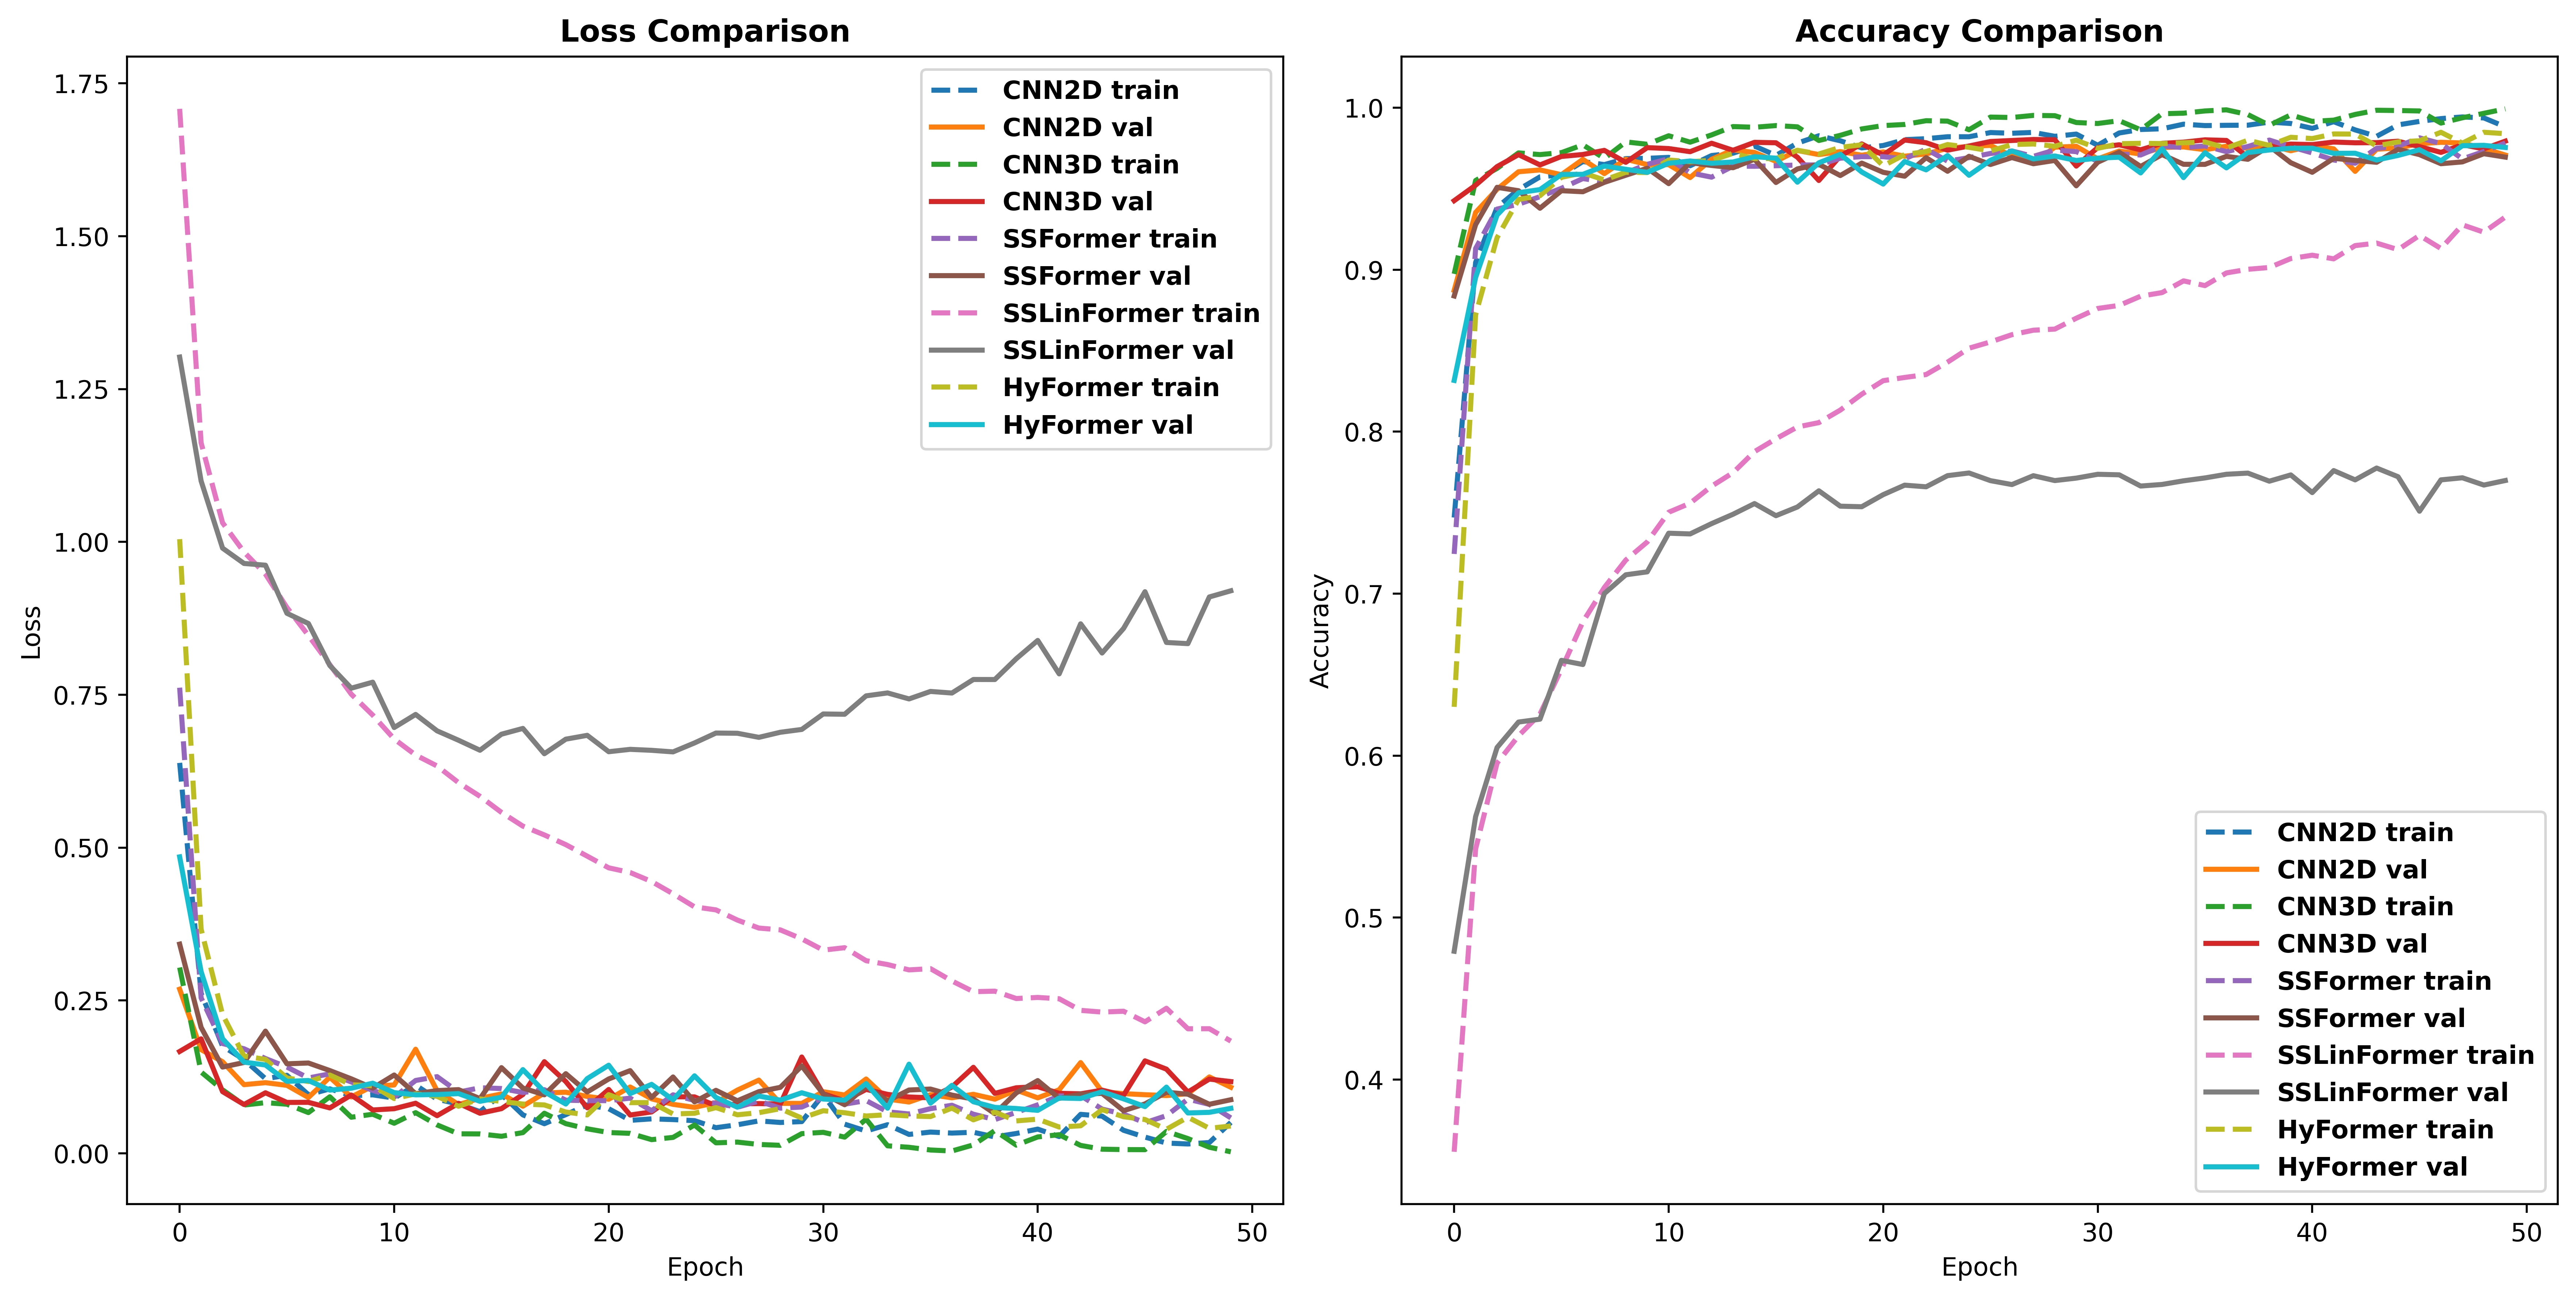

In [14]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 7),  # wide enough for two plots
    dpi=500,
    constrained_layout=True,
)

# ─── Plot Loss (Train & Val) ───────────────────────────────────────────────
for name, (tl, vl, ta, va) in all_hist.items():
    ax1.plot(tl, linestyle="--", linewidth=2, label=f"{name} train")
    ax1.plot(vl, linestyle="-", linewidth=2, label=f"{name} val")

ax1.set_title("Loss Comparison", fontweight="bold")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(
    # title="Models & Split",
    prop={"weight": "bold"},  # bold labels
    title_fontproperties={"weight": "bold"},  # bold title
)

# ─── Plot Accuracy (Train & Val) ──────────────────────────────────────────
for name, (tl, vl, ta, va) in all_hist.items():
    ax2.plot(ta, linestyle="--", linewidth=2, label=f"{name} train")
    ax2.plot(va, linestyle="-", linewidth=2, label=f"{name} val")

ax2.set_title("Accuracy Comparison", fontweight="bold")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(
    # title="Models & Split",
    prop={"weight": "bold"},
    title_fontproperties={"weight": "bold"},
)

# ─── Save & Show ──────────────────────────────────────────────────────────
output_path = os.path.join(RESULT_DIR, "compare_loss_acc_side_by_side.png")
fig.savefig(output_path, dpi=500)
plt.show()